In [1]:
import bayesfast as bf
import numpy as np

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:32921 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 126.70 GB


In [3]:
a = 5
b = 0.5

def f_0(x):
    return np.linalg.norm(x, 2, -1)

def j_0(x):
    '''not actually used'''
    foo = x / np.linalg.norm(x, 2, -1)
    return foo if np.all(np.isfinite(foo)) else np.ones_like(foo)

def f_1(x):
    return -(x - a)**2 / b

def j_1(x):
    return -2 * (x - a) / b

module_0 = bf.Module(fun=f_0, input_vars='x', output_vars='m')
module_1 = bf.Module(fun=f_1, jac=j_1, input_vars='m', output_vars='logp')

density_0 = bf.Density(module_list=[module_0, module_1], input_dims=[2],
                       input_vars='x', density_name='logp')
density_0.set_decay_options(use_decay=True)

surro_0 = bf.modules.PolyModel('linear', input_size=2, output_size=1,
                               input_vars='x', output_vars='m')
surro_1 = bf.modules.PolyModel('quadratic', input_size=2, output_size=1,
                               input_vars='x', output_vars='m')

x_0 = bf.utils.random.multivariate_normal([10, 10], np.eye(2), 20)

strace_0 = {'n_chain': 8, 'n_iter': 1000, 'n_warmup':500}

opt_0 = bf.recipe.OptimizeStep(surrogate_list=surro_0, x_0=x_0,
                               sample_trace=strace_0, random_state=0)
sam_0 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=5, reuse_samples=0,
                             sample_trace=strace_0, logp_cutoff=False)
sam_1 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=5, reuse_samples=1,
                             sample_trace=strace_0, logp_cutoff=False)

rec_0 = bf.recipe.Recipe(density=density_0, client=client, optimize=opt_0,
                         sample=[sam_0] * 5 + [sam_1] * 5, post=None)

In [4]:
rec_0.run()

 OptimizeStep proceeding: iter #0 finished.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:137: RuntimeWarning: the optimization stopped at [5.33912727 2.42802113], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #1 finished, while delta_pp = 0.373, delta_pq = 0.009.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:137: RuntimeWarning: the optimization stopped at [5.25678624 2.39071015], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #2 finished, while delta_pp = 0.297, delta_pq = 0.000.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:137: RuntimeWarning: the optimization stopped at [5.25678624 2.39071015], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #3 finished, while delta_pp = 0.000, delta_pq = 0.004.
 CHAIN #2 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.11 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.36 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.79 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.89 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 200 / 1000 ], last 200 samples used 4.92 seconds. (warmup)
 CHAIN #4 : sampling proceeding [ 200 / 1000 ], last 200 samples used 5.54 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 1000 ], last 200 samples used 4.19 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 400 / 1000 ], last 200 samples used 5.30 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 400 / 1000 ], last 200 samples used 5.03 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 400 / 1000 ], last 200 samples used 5.40 se

In [5]:
rec_0.recipe_trace.n_call

324

In [6]:
rec_0.recipe_trace.result.sample[-1].samples[-1]

array([-1.83357471,  4.52038194])

Removed no burn in


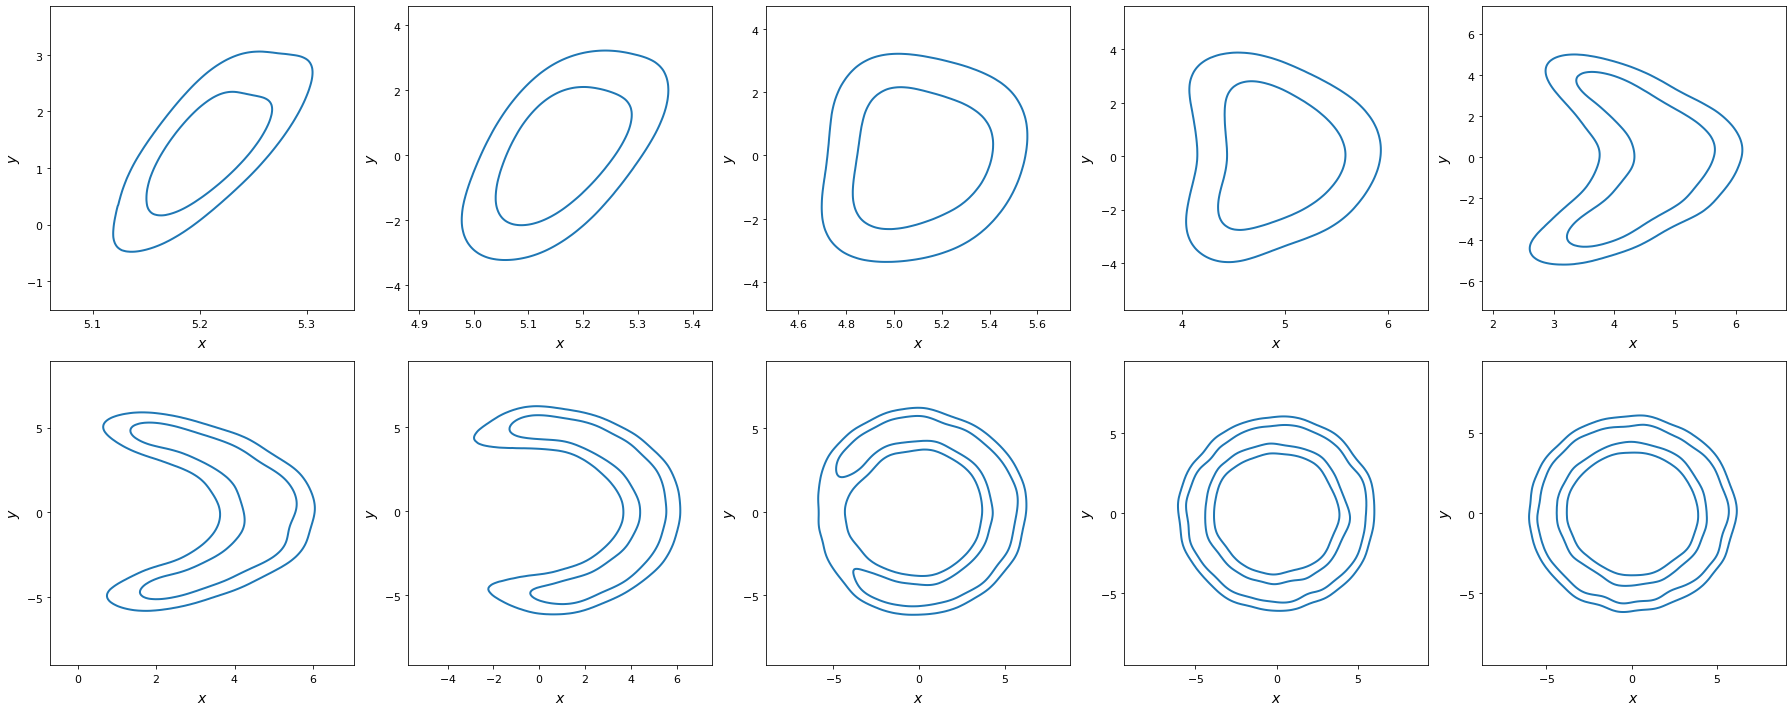

In [7]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

g = plots.get_subplot_plotter(subplot_size=5)
sa = MCSamples(samples=np.concatenate([si.samples.reshape((-1, 2)) for si in 
               rec_0.recipe_trace.result.sample], axis=-1),
               names=['x_{}'.format(i) for i in range(20)],
               labels=['x', 'y'] * 10)
g.plots_2d(sa, param_pairs=[['x_{}'.format(i), 'x_{}'.format(i + 1)] for i in 
           range(0, 20, 2)], nx=5, colors=['tab:blue'], lws=[2])

plt.show()